In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

import xarray as xr

import torch
import torch.nn as nn

In [2]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True) 
        
        self.fc = nn.Linear(hidden_size, 50*24)

    def forward(self, x):
        batch_size = x.size(0) # Get the batch size
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device) # Initial hidden state
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device) # Initial cell state
        
        out, _ = self.lstm(x, (h0, c0)) 
        out = self.fc(out[:, -1, :]) # Get the last output of the LSTM
        out = out.view(-1, 50, 24) # Reshape to (batch_size, mlat, mlt)
        return out
    
    def reset_states(self):
        # Reset the internal states of the LSTM layer
        self.lstm.reset_parameters()

# Instantiate the model with lookback size
lookback = 6
model = LSTM(lookback, 64, 2)
#device = 'cpu'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

LSTM(
  (lstm): LSTM(6, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1200, bias=True)
)

In [15]:
#import 2004 to 2006 data
df_open = pd.read_csv('/home/sachin/Documents/NIPR/Research/Data/OMNI/omni_hro2_5min_2004_2007.csv')
#df = df.groupby(['Timestamp_1hr_omni']).mean().reset_index()
#rename Timestamp 1hr omni to dt
df = df_open.rename(columns={'Timestamp_1min_omni': 'dt'})
df['dt'] = pd.to_datetime(df['dt'])
df = df.set_index('dt')
df = df.resample('10min').mean(numeric_only=True)
df = df.dropna()
df['doy_sin'] = np.sin(2*np.pi*df['doy']/365)
df['doy_cos'] = np.cos(2*np.pi*df['doy']/365)


df = df[['BX_GSE', 'BY_GSE', 'BZ_GSE', 'flow_speed', 'proton_density','F10.7', 'doy_sin', 'doy_cos']]
#df.isnull().sum()
#ds = df.to_xarray()
#ds
df

,BX_GSE,BY_GSE,BZ_GSE,flow_speed,proton_density,F10.7,doy_sin,doy_cos
dt,,,,,,,,
2004-01-01 00:00:00,-2.110,2.635,8.835,528.5,6.6350,112.0,1.721336e-02,0.999852
2004-01-01 00:10:00,-3.945,6.720,1.825,523.5,7.2050,112.0,1.721336e-02,0.999852
2004-01-01 00:20:00,-5.010,5.920,-0.365,523.0,7.2500,112.0,1.721336e-02,0.999852
2004-01-01 00:30:00,-5.655,5.090,5.855,522.5,6.1400,112.0,1.721336e-02,0.999852
2004-01-01 00:40:00,-4.765,8.570,-0.345,524.0,6.7150,112.0,1.721336e-02,0.999852
...,...,...,...,...,...,...,...,...
2007-12-31 23:10:00,-1.965,3.950,-1.525,350.0,6.9100,74.0,6.432491e-16,1.000000
2007-12-31 23:20:00,-2.950,2.475,-1.545,345.5,6.8950,74.0,6.432491e-16,1.000000
2007-12-31 23:30:00,-3.665,2.950,-1.655,345.0,6.9650,74.0,6.432491e-16,1.000000


In [18]:
def clock_angle(By, Bz):
    angle = np.rad2deg(np.arctan2(By, Bz))
    np.where(angle < 0, angle + 360, angle)
    angle = np.deg2rad(angle)
    return angle

def calc_akasofu(v_sw, Bx, By, Bz):
    #https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2002JA009283
    #In SI units
    v_sw = v_sw * 1e3
    Bx = Bx * 10e-9
    By = By * 10e-9
    Bz = Bz * 10e-9
    B = np.sqrt(Bx**2 + By**2 + Bz**2)
    l_0 = 6371 * 7 * 1e3 #7 R_E
    mu_0 = np.pi * 4 * 10e-6
    #mu_0 = 1.2566370614e-6
    theta  = clock_angle(By, Bz)
    epsilon_A = (4 * np.pi / mu_0) * v_sw * B**2 * np.sin(theta / 2)**4 * l_0**2
    #epsilon_A = np.log10(epsilon_A + 1)

    return epsilon_A

df['epislon_A'] = calc_akasofu(df['flow_speed'], df['BX_GSE'], df['BY_GSE'], df['BZ_GSE'])
df


,BX_GSE,BY_GSE,BZ_GSE,flow_speed,proton_density,F10.7,doy_sin,doy_cos,epislon_A
dt,,,,,,,,,
2004-01-01 00:00:00,-2.110,2.635,8.835,528.5,6.6350,112.0,1.721336e-02,0.999852,4.089931e+08
2004-01-01 00:10:00,-3.945,6.720,1.825,523.5,7.2050,112.0,1.721336e-02,0.999852,9.078507e+10
2004-01-01 00:20:00,-5.010,5.920,-0.365,523.0,7.2500,112.0,1.721336e-02,0.999852,1.766427e+11
2004-01-01 00:30:00,-5.655,5.090,5.855,522.5,6.1400,112.0,1.721336e-02,0.999852,1.440965e+10
2004-01-01 00:40:00,-4.765,8.570,-0.345,524.0,6.7150,112.0,1.721336e-02,0.999852,2.714086e+11
...,...,...,...,...,...,...,...,...,...
2007-12-31 23:10:00,-1.965,3.950,-1.525,350.0,6.9100,74.0,6.432491e-16,1.000000,7.015317e+10
2007-12-31 23:20:00,-2.950,2.475,-1.545,345.5,6.8950,74.0,6.432491e-16,1.000000,6.918787e+10
2007-12-31 23:30:00,-3.665,2.950,-1.655,345.0,6.9650,74.0,6.432491e-16,1.000000,9.463754e+10


In [19]:
def split_to_df(df):

    df = df.reset_index()

    df_2 = df.copy()
    df_2 = df_2.drop(columns=['dt'])
    
    return df, df_2

df_raw, df_proc = split_to_df(df)

with open(f'/home/sachin/Documents/NIPR/Research/Data/ML/AMP_LSTM/scaler_id3.pkl', 'rb') as f:
    scaler = pickle.load(f)

col_names = df_proc.columns
norm_arr = scaler.transform(df_proc)
df_proc = pd.DataFrame(norm_arr, columns=col_names)
df_proc = df_proc.to_numpy()

/home/sachin/miniconda3/envs/torch_env/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [20]:
def create_sequences(arr, lookback=6):
    X = []
    for i in range(len(arr) - lookback):
        X.append(arr[i:i+lookback].T)

    X = np.array(X)

    return X

proc_seq = create_sequences(df_proc)
proc_seq = torch.tensor(proc_seq, dtype=torch.float32).to(device)

In [21]:
predictions = []
with torch.no_grad():
    for i in range(len(proc_seq)):
        pred = model(proc_seq[i].unsqueeze(0))
        predictions.append(pred)

predictions = torch.cat(predictions)
predictions = predictions.to('cpu').numpy()

In [22]:
ds = xr.Dataset({'jPar_NH': (['dt', 'mlat', 'mlt'], predictions)},
                coords = {'dt': df_raw['dt'].values[lookback:], 'mlat': np.arange(40, 90, 1), 'mlt': np.arange(0, 24, 1)})
#ds = ds.resample(dt='1D').mean()
ds

<xarray.Dataset> Size: 980MB
Dimensions:  (dt: 203829, mlat: 50, mlt: 24)
Coordinates:
  * dt       (dt) datetime64[ns] 2MB 2004-01-01T01:00:00 ... 2007-12-31T23:50:00
  * mlat     (mlat) int64 400B 40 41 42 43 44 45 46 47 ... 83 84 85 86 87 88 89
  * mlt      (mlt) int64 192B 0 1 2 3 4 5 6 7 8 9 ... 15 16 17 18 19 20 21 22 23
Data variables:
    jPar_NH  (dt, mlat, mlt) float32 978MB 0.0352 -0.0662 ... -0.09527 0.06369

(array([4.0000000e+00, 1.9000000e+01, 9.0000000e+01, 1.0900000e+03,
        8.4420000e+03, 7.6553000e+04, 1.7927600e+05, 5.2292800e+05,
        2.7105100e+05, 8.9754500e+05, 1.9478560e+06, 2.7418170e+06,
        4.1043400e+06, 5.8074960e+06, 6.6540260e+06, 7.1699390e+06,
        9.2395500e+06, 1.0867861e+07, 1.1724190e+07, 1.3067161e+07,
        1.1968944e+07, 1.2822961e+07, 1.0290750e+07, 1.1344584e+07,
        9.8496530e+06, 9.7316430e+06, 9.9318470e+06, 1.1605840e+07,
        1.3305292e+07, 1.0974511e+07, 1.0239535e+07, 7.7178780e+06,
        9.9697740e+06, 7.3186670e+06, 7.0763160e+06, 4.6251680e+06,
        4.4285980e+06, 2.5489550e+06, 2.0115660e+06, 9.1834700e+05,
        3.2917300e+05, 9.1466000e+04, 7.8260000e+03, 4.1636000e+04,
        1.0675400e+05, 5.4086000e+04, 1.7310000e+03, 5.3000000e+01,
        1.0000000e+01, 2.0000000e+00]),
 array([-0.27144107, -0.26026088, -0.24908069, -0.2379005 , -0.2267203 ,
        -0.21554013, -0.20435993, -0.19317974, -0.18199955, -0.17081936

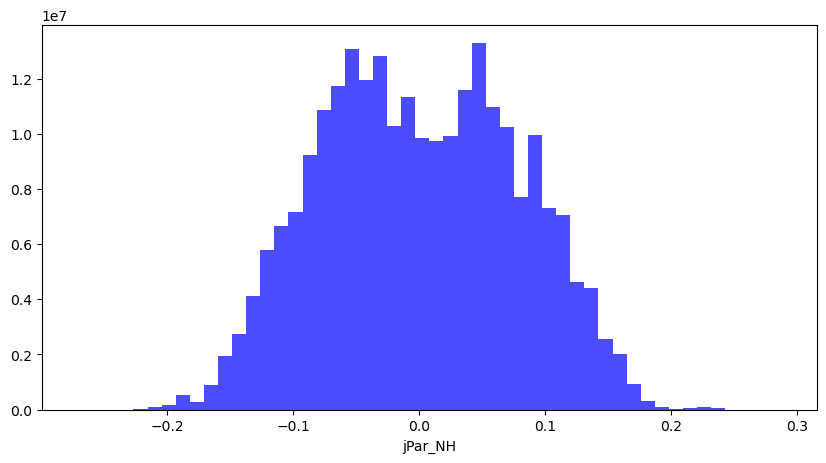

In [23]:
#histogram
fig, ax = plt.subplots(figsize=(10, 5))
ds['jPar_NH'].plot.hist(ax=ax, bins=50, color='blue', alpha=0.7)

<>:25: SyntaxWarning: invalid escape sequence '\p'
<>:25: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_68382/2448488685.py:25: SyntaxWarning: invalid escape sequence '\p'
  plt.ylabel('FAC (J$_\parallel$) [µA/m$^2$]')


Text(0, 0.5, 'FAC (J$_\\parallel$) [µA/m$^2$]')

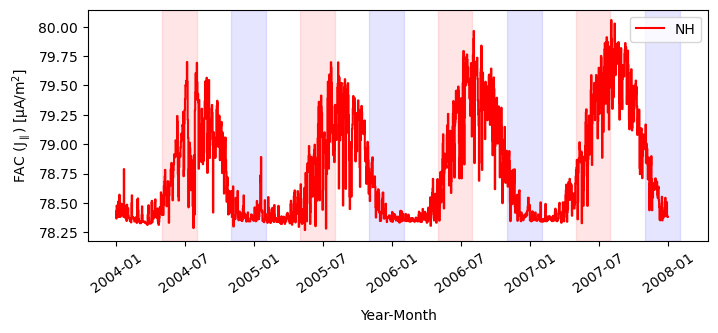

In [12]:
dt = ds['dt'].values.flatten()
jpar_NH = ds['jPar_NH'].values
jpar_NH = np.abs(jpar_NH).sum(axis=(1,2)).flatten()

fig, ax = plt.subplots(1, 1, figsize=(8, 3))


sns.lineplot(x=dt, y=jpar_NH, label='NH', color='red',drawstyle='steps-pre')
#sns.lineplot(x=dt, y=jpar_SH, label='SH', color='blue',drawstyle='steps-pre')

#add light blue shape between november and january for all years
nov = pd.Timestamp('11-01')
jan = pd.Timestamp('01-01')
for i in range(2004, 2008):
    ax.axvspan(pd.Timestamp(f'{i}-11-01'), pd.Timestamp(f'{i+1}-02-01'), color='blue', alpha=0.1)

#may = pd.Timestamp('05-01')
#jul = pd.Timestamp('07-01')
for i in range(2004, 2008):
    ax.axvspan(pd.Timestamp(f'{i}-05-01'), pd.Timestamp(f'{i}-08-01'), color='red', alpha=0.1)

plt.xlabel('Year-Month', labelpad=10)
#rotate x-axis labels
plt.xticks(rotation=35)
plt.ylabel('FAC (J$_\parallel$) [µA/m$^2$]')

<>:28: SyntaxWarning: invalid escape sequence '\p'
<>:28: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_68382/1527408799.py:28: SyntaxWarning: invalid escape sequence '\p'
  plt.colorbar(c, ax=ax, label='J$_\parallel$ (FAC) [µA/m$^2$]', shrink=0.5, pad = 0.18,


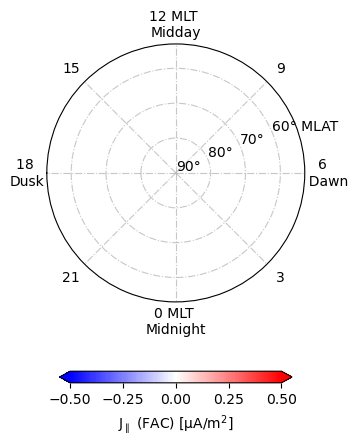

In [13]:
fac = ds['jPar_NH'].values.mean(axis=0)

#fac = fac.reshape(24, 50).T # reshape and transpose
#fac = np.flipud(fac) # flip the array upside down
theta = np.linspace(0, 360, 24) - 90 # rotate by 90 degrees
theta = np.radians(theta) # convert to radians
r = 90 - np.linspace(40, 89, 50) #convert to colat

#cmap = mcolors.LinearSegmentedColormap.from_list("my_colormap", ["blue","blue", "white", "white","red","red"])
cmap = 'bwr'

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6, 5))

c = ax.contourf(theta, r, fac, cmap=cmap, levels=np.linspace(-.5, .5, 100), extend='both')
ax.set_ylim([0,37])
ax.set_yticks([0, 10, 20, 30])
ax.set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
ax.set_xlim([-np.pi, np.pi])
ax.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
ax.set_xticklabels(["21", "0 MLT \nMidnight", "3", "6 \n  Dawn", "9", "12 MLT \nMidday", "15", "18 \nDusk"])
ax.grid(True, linestyle='-.', alpha=0.7)
#ax.set_title(f"{dt}", pad=10, fontsize=11.5)

#add text above colorbar
#ax.text(0.73, -0.22, 'NH Stronger', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=10)
#ax.text(0.27, -0.22, 'SH Stronger', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=10)

plt.colorbar(c, ax=ax, label='J$_\parallel$ (FAC) [µA/m$^2$]', shrink=0.5, pad = 0.18, 
             ticks=[-.5, -.25, 0, 0.25, 0.5], 
             orientation='horizontal')

#plt.savefig('LSTM_NH_SH_current_asymmetry_bartels.png', dpi=500, bbox_inches='tight')
